In [1]:
from opr_structs import *
from opr_logic import *
from pprint import pprint
import copy
import itertools

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")
logger.setLevel(logging.WARNING)

from contextlib import contextmanager

@contextmanager
def loggingcm(level=logging.DEBUG):
    # Code to acquire resource, e.g.:
    logger.setLevel(level)
    try:
        yield
    finally:
        # Code to release resource, e.g.:
        logger.setLevel(logging.WARNING)

with loggingcm():
    logger.debug("debug1")
logger.debug("debug2")

DEBUG:root:test
DEBUG:root:debug1


In [3]:
from units import *
from opr_ai import *

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_items(ax, items, name_func, color=None):
    y = []
    x = []
    names = []
    for i in items:
        x.append(i.x)
        y.append(i.y)
        name = name_func(i) #f"{u.name} ({len(u.models)}/{u.starting_models})"
        names.append(name)
    
    ax.scatter(x, y)
    for i, n in enumerate(names):
        ax.annotate(n, (x[i], y[i]))

def draw_terrain(ax, terrain):
    for t in terrain:
        circ = Circle((t.x, t.y), radius=t.diameter/2, alpha=0.5, color=t.rules.get("Color"))
        ax.add_patch(circ)
    

def plot_battle(battle, cursor_x=0, cursor_y=0):
    fig = plt.figure(figsize=(10,8))
    ax = fig.subplots()
    for p in battle.players:
        plot_items(ax, [u for u in p.units if u.alive], lambda u: f"{u.name} ({len(u.models)}/{u.starting_models})")
    
    plot_items(ax, battle.objectives, lambda o: f"{o.controller}")
    
    draw_terrain(ax, battle.terrain)
    
    ax.scatter(cursor_x, cursor_y, c="red")
    ax.set_xlim([0, 72])
    ax.set_ylim([0, 48])
    
    
    plt.gca().set_aspect('equal')
    

    plt.show()

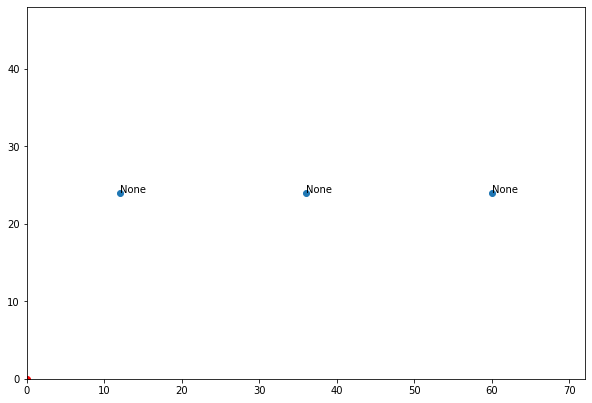

In [5]:
plot_battle(Battle([]))

In [6]:
class Terrain:
    def __init__(self, diameter, rules):
        self.rules = rules
        self.x = 0
        self.y = 0
        self.diameter = diameter
    
    def __repr__(self):
        return f"Terrain({self.diameter}, {self.rules}, {self.x}, {self.y})"

In [7]:
forest = Terrain(8, {"Cover":True, "Difficult":True, "Color": 'g'})
rock = Terrain(4, {"Blocking":True, "Cover": True, "Color": '0.5'})


In [8]:
def place_terrain(battle):
    for t in battle.terrain:
        t.x = random.randint(6, 6*12-6)
        t.y = random.randint(6, 4*12-6)

In [9]:
b = Battle([])
b.terrain = copify([forest,forest,forest,forest,forest,forest,forest,forest,forest,forest,])
# b.terrain = copify([forest,forest,])
place_terrain(b)
b.terrain[0].x = 40
b.terrain[0].y = 8

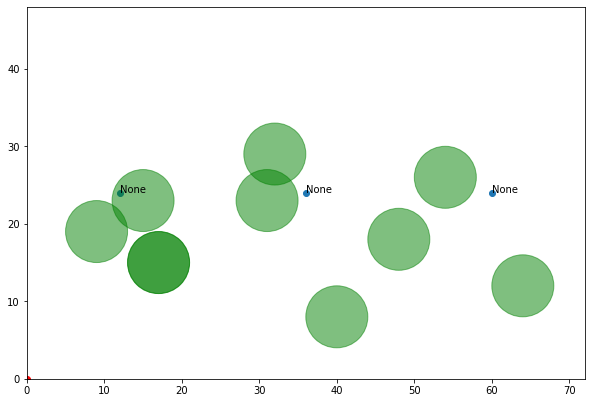

In [10]:
plot_battle(b)

In [11]:
def terrain_collision(start, end, radius, terrain):
    collisions = []
    for t in terrain:
        to_end = calc_distance(*unpack_points(t, end))
        to_start = calc_distance(*unpack_points(t, start))
        from_line = line_point_distance(start, end, t)
        between = calc_distance(*unpack_points(start, end))
#         print(to_end, to_start, from_line, t)
        
        td = (t.diameter / 2) + radius
        btd = td + between
        if to_end < td or to_start < td or (from_line < td and to_end < btd and to_start < btd):
            collisions.append(t)
    return collisions

In [12]:
terrain_collision(Point(30, 8), Point(50, 8), 2, b.terrain)

[Terrain(8, {'Cover': True, 'Difficult': True, 'Color': 'g'}, 40, 8)]

In [17]:
import random
def nvn_full(a, b, draw_value=0.5):
    random.shuffle(a)
    random.shuffle(b)
    # start units at 12x12 and increment by 6 for each
    # spread units along the front
    center = 36
    edge = 6
#     spacing = (2 * center) / (len(a))
#     for i, u in enumerate(a):
#         u.y = 11.5
#         u.x = random.randint(6, 6*12-1)
    
#     spacing = (2 * center) / (len(b))
#     for i, u in enumerate(b):
#         u.y = 36.5
#         u.x = 6 + i * spacing

    
        
    p1 = Player("p1", a, (0, 12, 0, 72))
    p2 = Player("p2", b, (36, 48, 0, 72))
    
#     p1.activation = advanced_activation
    p1.activation = basic_activation
    p2.activation = basic_activation
    
    battle = Battle([p1, p2])
#     obj_x = 6 + (len(a) - 1) * 3
#     battle.objectives = [Objective(36, 24),]
#     check_objectives(battle)

    battle.terrain = copify([forest,] * 15)
    place_terrain(battle)

    deploy(battle)
    
#     def on_line(units, y):
#         for i, u in enumerate(units):
#             u.y = y
#             u.x = random.randint(6, 6*12-1)
            
#     on_line(p1.units, 11.5 - 6)
#     on_line(p2.units, 36.5 + 6)
    
#     spacing = (2 * center) / (len(p2.units))
#     for i, u in enumerate(p2.units):
#         u.y = 36.5 + 10
#         u.x = random.randint(6, 6*12-1)
    
#     run_battle(battle)
    if logger.getEffectiveLevel() <= 10:
        plot_battle(battle)
    next_player = 0
    for i in range(4):
        next_player = do_round(battle, next_player)
        if logger.getEffectiveLevel() <= 10:
            plot_battle(battle)
            print("Units:")
            pprint(battle.all_units)
            pprint(battle.objectives)
    
    p1_score = sum([1 for o in battle.objectives if o.controller == p1.name])
    p2_score = sum([1 for o in battle.objectives if o.controller == p2.name])
    
        
    if p1_score == p2_score:
        return 0.5
    elif p1_score > p2_score:
        return 1
    else:
        return 0

In [18]:
import tqdm
def mc(func, times=10000):
    results = []
    for i in tqdm.tqdm(range(times)):
        results.append(func())
        
    print([(k, len(list(g))) for k, g in itertools.groupby(sorted(results))])
    
    return sum(results) / len(results)

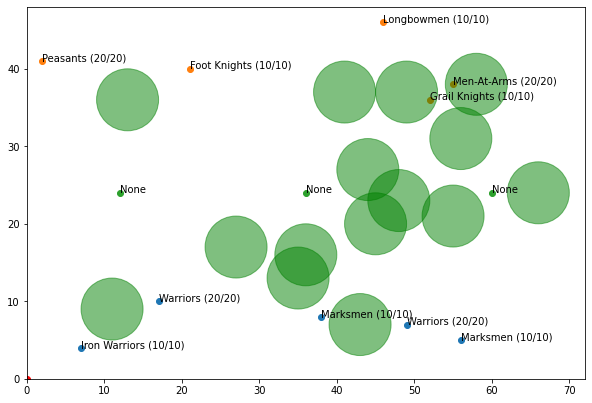

DEBUG:opr_logic:Starting Round 1
DEBUG:opr_logic:executing p1 Unit(Warriors (20/20)(17.0,10.0), ('Rush', 8, 2.79856871316909)
DEBUG:opr_logic:executing p2 Unit(Grail Knights (10/10)(52.0,36.0), ('Rush', 16, -0.5880026035475675)
DEBUG:opr_logic:executing p1 Unit(Iron Warriors (10/10)(7.0,4.0), ('Rush', 8, -2.896613990462929)
DEBUG:opr_logic:executing p2 Unit(Peasants (20/20)(2.0,41.0), ('Advance', 6, -0.47329561833328576, Unit(Warriors a(20/20)(15.0,15.7))
DEBUG:opr_logic:Unit(Peasants a(20/20)(4.7,35.7) shooting at Unit(Warriors a(20/20)(15.0,15.7)
DEBUG:opr_logic:Out of range
DEBUG:opr_logic:executing p1 Unit(Marksmen (10/10)(56.0,5.0), ('Advance', 4, 3.1157676281709614, Unit(Grail Knights a(10/10)(55.3,31.0))
DEBUG:opr_logic:Unit(Marksmen a(10/10)(55.9,9.0) shooting at Unit(Grail Knights a(10/10)(55.3,31.0)
DEBUG:opr_logic:Out of range
DEBUG:opr_logic:executing p2 Unit(Longbowmen (10/10)(46.0,46.0), ('Advance', 6, -0.26135134958469197, Unit(Marksmen a(10/10)(55.9,9.0))
DEBUG:opr_logi

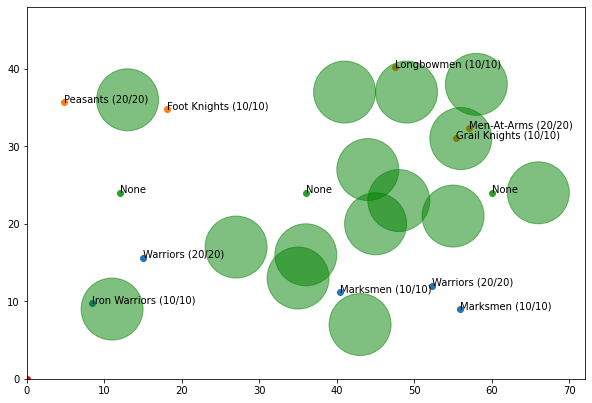

DEBUG:opr_logic:Starting Round 2
DEBUG:opr_logic:executing p1 Unit(Warriors (20/20)(15.0,15.7), ('Rush', 8, 2.79856871316909)
DEBUG:opr_logic:executing p2 Unit(Grail Knights (10/10)(55.3,31.0), ('Rush', 10.922205101855958, -0.5880026035475675)
DEBUG:opr_logic:executing p1 Unit(Marksmen (10/10)(40.4,11.2), ('Advance', 4, -2.2561464944097067, Unit(Grail Knights a(10/10)(58.6,26.1))
DEBUG:opr_logic:Unit(Marksmen a(10/10)(43.5,13.7) shooting at Unit(Grail Knights a(10/10)(58.6,26.1)
DEBUG:opr_logic:Out of range
DEBUG:opr_logic:executing p2 Unit(Men-At-Arms (20/20)(57.0,32.3), ('Rush', 11.366068747318502, -0.34302394042070344)
DEBUG:opr_logic:executing p1 Unit(Warriors (20/20)(52.3,12.0), ('Rush', 8, -2.5672878234150915)
DEBUG:opr_logic:executing p2 Unit(Longbowmen (10/10)(47.6,40.2), ('Advance', 6, -0.3317971603100005, Unit(Warriors a(20/20)(55.5,17.1))
DEBUG:opr_logic:Unit(Longbowmen a(10/10)(49.5,34.5) shooting at Unit(Warriors a(20/20)(55.5,17.1)
DEBUG:opr_logic:10 attacks
DEBUG:opr_log

Units:
[Unit(Iron Warriors a(10/10)(8.5,9.8),
 Unit(Warriors a(20/20)(52.3,12.0),
 Unit(Marksmen a(10/10)(40.4,11.2),
 Unit(Warriors a(20/20)(15.0,15.7),
 Unit(Marksmen a(10/10)(55.9,9.0),
 Unit(Peasants a(20/20)(4.7,35.7),
 Unit(Longbowmen a(10/10)(47.6,40.2),
 Unit(Men-At-Arms a(20/20)(57.0,32.3),
 Unit(Foot Knights a(10/10)(18.1,34.8),
 Unit(Grail Knights a(10/10)(55.3,31.0)]
[Objective(12, 24, None), Objective(36, 24, None), Objective(60, 24, None)]


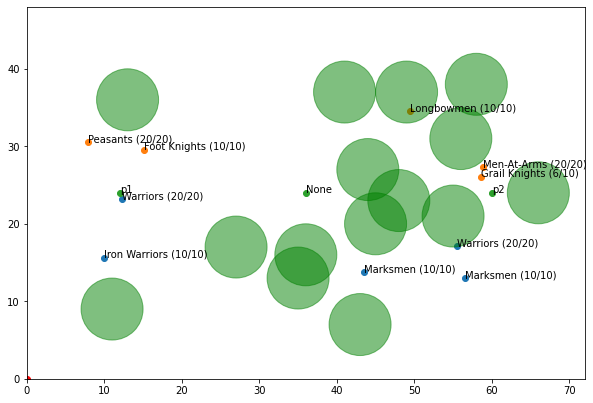

DEBUG:opr_logic:Starting Round 3
DEBUG:opr_logic:executing p1 Unit(Marksmen (10/10)(43.5,13.7), ('Advance', 4, -2.860738017831947, Unit(Grail Knights (6/10)(58.6,26.1))
DEBUG:opr_logic:Unit(Marksmen a(10/10)(44.6,17.6) shooting at Unit(Grail Knights (6/10)(58.6,26.1)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:Target has cover
DEBUG:opr_logic:4 hits
DEBUG:opr_logic:0 wounds
DEBUG:opr_logic:executing p2 Unit(Grail Knights (6/10)(58.6,26.1), ('Rush', 16, 1.479067437093123)
DEBUG:opr_logic:executing p1 Unit(Warriors (20/20)(12.3,23.2), ('Rush', 8, -1.6051841839685952)
DEBUG:opr_logic:executing p2 Unit(Peasants (20/20)(7.8,30.5), ('Advance', 6, -1.0542107640065648, Unit(Warriors a(20/20)(20.3,23.5))
DEBUG:opr_logic:Unit(Peasants a(20/20)(13.1,27.6) shooting at Unit(Warriors a(20/20)(20.3,23.5)
DEBUG:opr_logic:20 attacks
DEBUG:opr_logic:4 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:executing p1 Unit(Iron Warriors (10/10)(9.9,15.6), ('Rush', 8, -1.8808339508893321)
DEBUG:opr_logic:executing

Units:
[Unit(Iron Warriors a(10/10)(9.9,15.6),
 Unit(Warriors a(20/20)(55.5,17.1),
 Unit(Marksmen a(10/10)(43.5,13.7),
 Unit(Warriors a(20/20)(12.3,23.2),
 Unit(Marksmen a(10/10)(56.5,12.9),
 Unit(Peasants a(20/20)(7.8,30.5),
 Unit(Longbowmen a(10/10)(49.5,34.5),
 Unit(Men-At-Arms a(20/20)(58.8,27.3),
 Unit(Foot Knights a(10/10)(15.1,29.5),
 Unit(Grail Knights a(6/10)(58.6,26.1)]
[Objective(12, 24, p1), Objective(36, 24, None), Objective(60, 24, p2)]


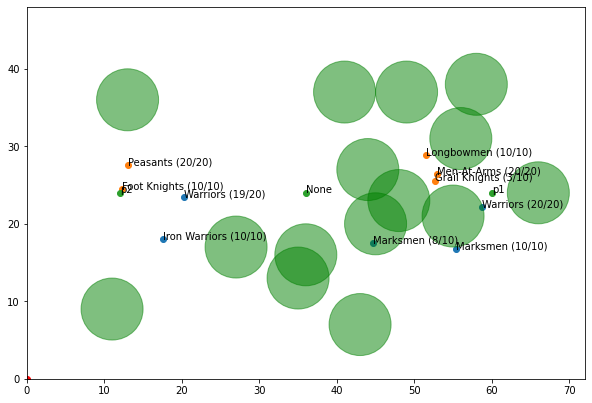

DEBUG:opr_logic:Starting Round 4
DEBUG:opr_logic:executing p1 Unit(Marksmen (10/10)(55.3,16.8), ('Advance', 4, 2.892204942136822, Unit(Grail Knights s(3/10)(52.6,25.5))
DEBUG:opr_logic:Unit(Marksmen a(10/10)(54.4,20.6) shooting at Unit(Grail Knights s(3/10)(52.6,25.5)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:Target has cover
DEBUG:opr_logic:5 hits
DEBUG:opr_logic:3 wounds
DEBUG:opr_logic:executing p2 Unit(Foot Knights (10/10)(12.2,24.4), ('Charge', Unit(Warriors (19/20)(20.3,23.5))
DEBUG:opr_logic:Unit(Foot Knights a(10/10)(18.3,23.7) strikes Unit(Warriors (19/20)(20.3,23.5)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:6 hits
DEBUG:opr_logic:5 wounds
DEBUG:opr_logic:Unit(Warriors (14/20)(20.3,23.5) strikes Unit(Foot Knights fa(10/10)(18.3,23.7)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:4 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:scores: a: 6, d: 3
DEBUG:opr_structs:Warriors doing morale test
DEBUG:opr_structs:Warriors failed morale test
DEBUG:opr_logic:executing p1 Unit(Iron Warri

Units:
[Unit(Iron Warriors a(10/10)(17.5,18.1),
 Unit(Warriors a(20/20)(58.8,22.1),
 Unit(Marksmen a(8/10)(44.6,17.6),
 Unit(Warriors a(19/20)(20.3,23.5),
 Unit(Marksmen a(10/10)(55.3,16.8),
 Unit(Peasants a(20/20)(13.1,27.6),
 Unit(Longbowmen a(10/10)(51.5,28.9),
 Unit(Men-At-Arms a(20/20)(52.9,26.4),
 Unit(Foot Knights a(10/10)(12.2,24.4),
 Unit(Grail Knights sa(3/10)(52.6,25.5)]
[Objective(12, 24, p2), Objective(36, 24, None), Objective(60, 24, p1)]


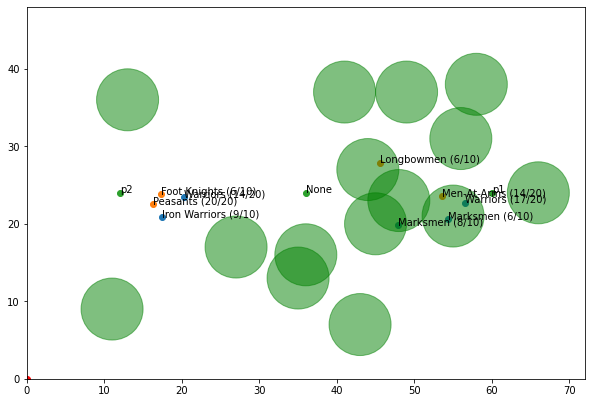

Units:
[Unit(Iron Warriors fa(9/10)(17.4,20.8),
 Unit(Warriors fa(17/20)(56.5,22.7),
 Unit(Marksmen a(8/10)(47.9,19.8),
 Unit(Warriors fa(14/20)(20.3,23.5),
 Unit(Marksmen fsa(6/10)(54.4,20.6),
 Unit(Peasants a(20/20)(16.3,22.5),
 Unit(Longbowmen a(6/10)(45.5,27.8),
 Unit(Men-At-Arms fsa(14/20)(53.6,23.6),
 Unit(Foot Knights fsa(6/10)(17.3,23.8),
 Unit(Grail Knights s(0/10)(52.6,25.5)]
[Objective(12, 24, p2), Objective(36, 24, None), Objective(60, 24, p1)]
0.5


In [22]:
# a = [men_at_arms,longbowmen_10,peasants,grail_knights_c,foot_knights,]
# a = [treemen_c,treemen_c,bow_revenants,forest_guards_c,forest_riders]
a = [warriors,warriors,rifle_dwarves_c,iron_warriors,rifle_dwarves_c,]
b = [men_at_arms,longbowmen_10,peasants,grail_knights_c,foot_knights,]
# b = [warriors,warriors,rifle_dwarves_c,iron_warriors,rifle_dwarves_c,]
with loggingcm(): print(nvn_full(copify(a), copify(b)))

In [23]:
a_first = mc(lambda: nvn_full(copify(a), copify(b)), times=10000)
b_first = 1 - mc(lambda: nvn_full(copify(b), copify(a)), times=10000)
(a_first + b_first) / 2, a_first, b_first

100%|████████████████████████████████████| 10000/10000 [01:23<00:00, 119.50it/s]


[(0, 2930), (0.5, 3234), (1, 3836)]


100%|████████████████████████████████████| 10000/10000 [01:24<00:00, 118.46it/s]

[(0, 3806), (0.5, 3201), (1, 2993)]


(0.542975, 0.5453, 0.5406500000000001)

base: (0.49805, 0.5044, 0.4917)
dwarves vs base: (0.544725, 0.54335, 0.5461)
WE vs base: (0.544475, 0.55035, 0.5386)
WE vs dwarves: (0.48285, 0.47825, 0.48745000000000005)

with cover:
WE vs dwarves: (0.48955000000000004, 0.4855, 0.49360000000000004)

with 15 forests: 
WE vs Dwarves: (0.51485, 0.5117, 0.518)
Dwarves vs CK: (0.542975, 0.5453, 0.5406500000000001)